# Logistic Regression Task

The goal of this task was to analyze the Portuguese bank marketing dataset to build a model predicting whether a client subscribes to a term deposit ("y"), based on demographic and campaign variables. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to assess if the product (bank term deposit) would be (or not) subscribed.

The full dataset was described and analyzed in [Moro et al., 2011]

---

## Loading and inspecting the dataset

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, roc_curve, confusion_matrix, classification_report,
    precision_recall_curve, average_precision_score, brier_score_loss
)
from sklearn.feature_selection import RFECV
from imblearn.over_sampling import SMOTE

In [37]:
bank = pd.read_csv("bank-full.csv", sep=';')

In [38]:
display(bank.head())
display(bank.info())
display(bank.describe(include='all').T)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,45211.0,NaN,NaN,NaN,40.93621,10.618762,18.0,33.0,39.0,48.0,95.0
job,45211,12,blue-collar,9732,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital,45211,3,married,27214,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education,45211,4,secondary,23202,NaN,NaN,NaN,NaN,NaN,NaN,NaN
default,45211,2,no,44396,NaN,NaN,NaN,NaN,NaN,NaN,NaN
balance,45211.0,NaN,NaN,NaN,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
housing,45211,2,yes,25130,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan,45211,2,no,37967,NaN,NaN,NaN,NaN,NaN,NaN,NaN
contact,45211,3,cellular,29285,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day,45211.0,NaN,NaN,NaN,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0


In [4]:
bank.duplicated().sum()

np.int64(0)

No missing or duplicate values in the dataset

In [5]:
# Converting binary string columns to numeric 1 or 0:
bank['y'] = bank['y'].map({'yes': 1, 'no': 0})

bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0


---

## Exploring the dataset

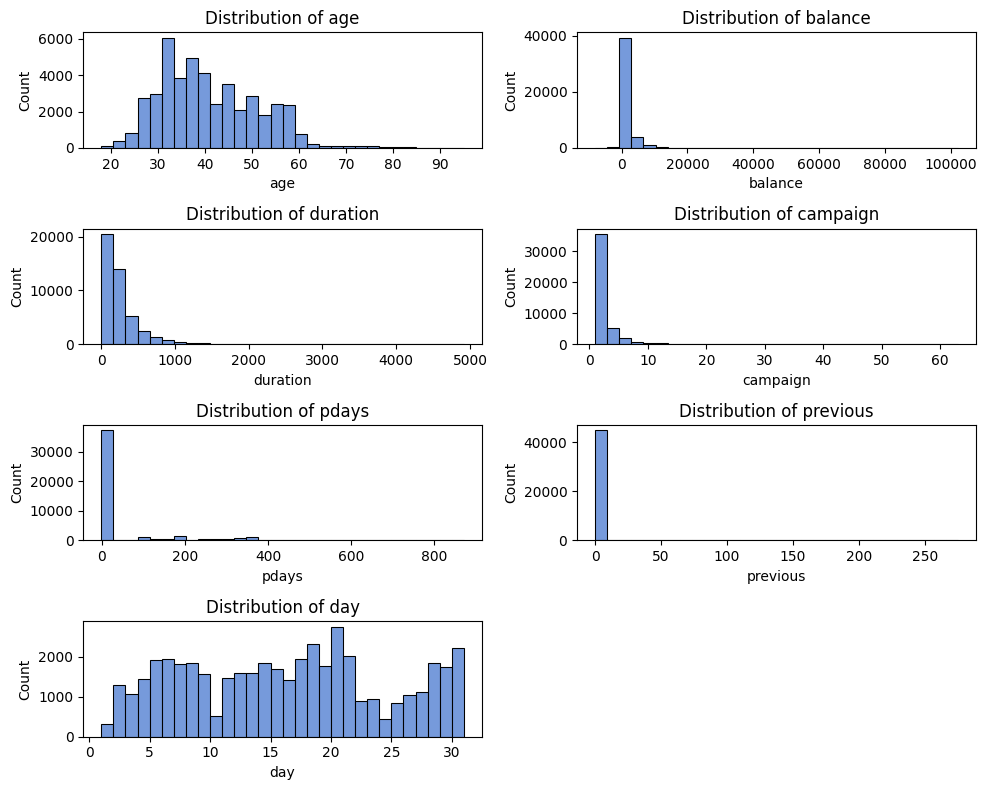

In [6]:
numeric_columns = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous', 'day']

default_color = sns.color_palette("muted")[0]
secondary_color = sns.color_palette("muted")[6]

plt.figure(figsize=(10, 8))

for i, col in enumerate(numeric_columns, 1):
    plt.subplot(4,2,(i))
    sns.histplot(bank[col], bins=30, color = default_color)
    plt.title(f"Distribution of {col}")

plt.tight_layout()
plt.savefig("Histograms.png")
plt.show()

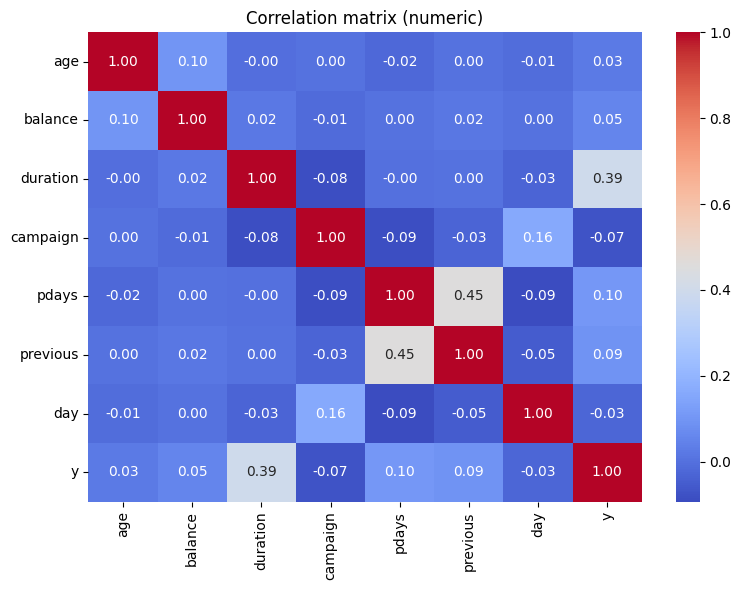

In [7]:
plt.figure(figsize=(8,6))
sns.heatmap(bank[numeric_columns + ['y']].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation matrix (numeric)")

plt.tight_layout()
plt.savefig("CorrelationMatrix.png")
plt.show()

Y is somewhat correlated with duration. Small correlation is between y and pdays and y and previous. Other metrics, such as age, balance or day show negligible correlation. 

Checking the distribution of categorical variables against 

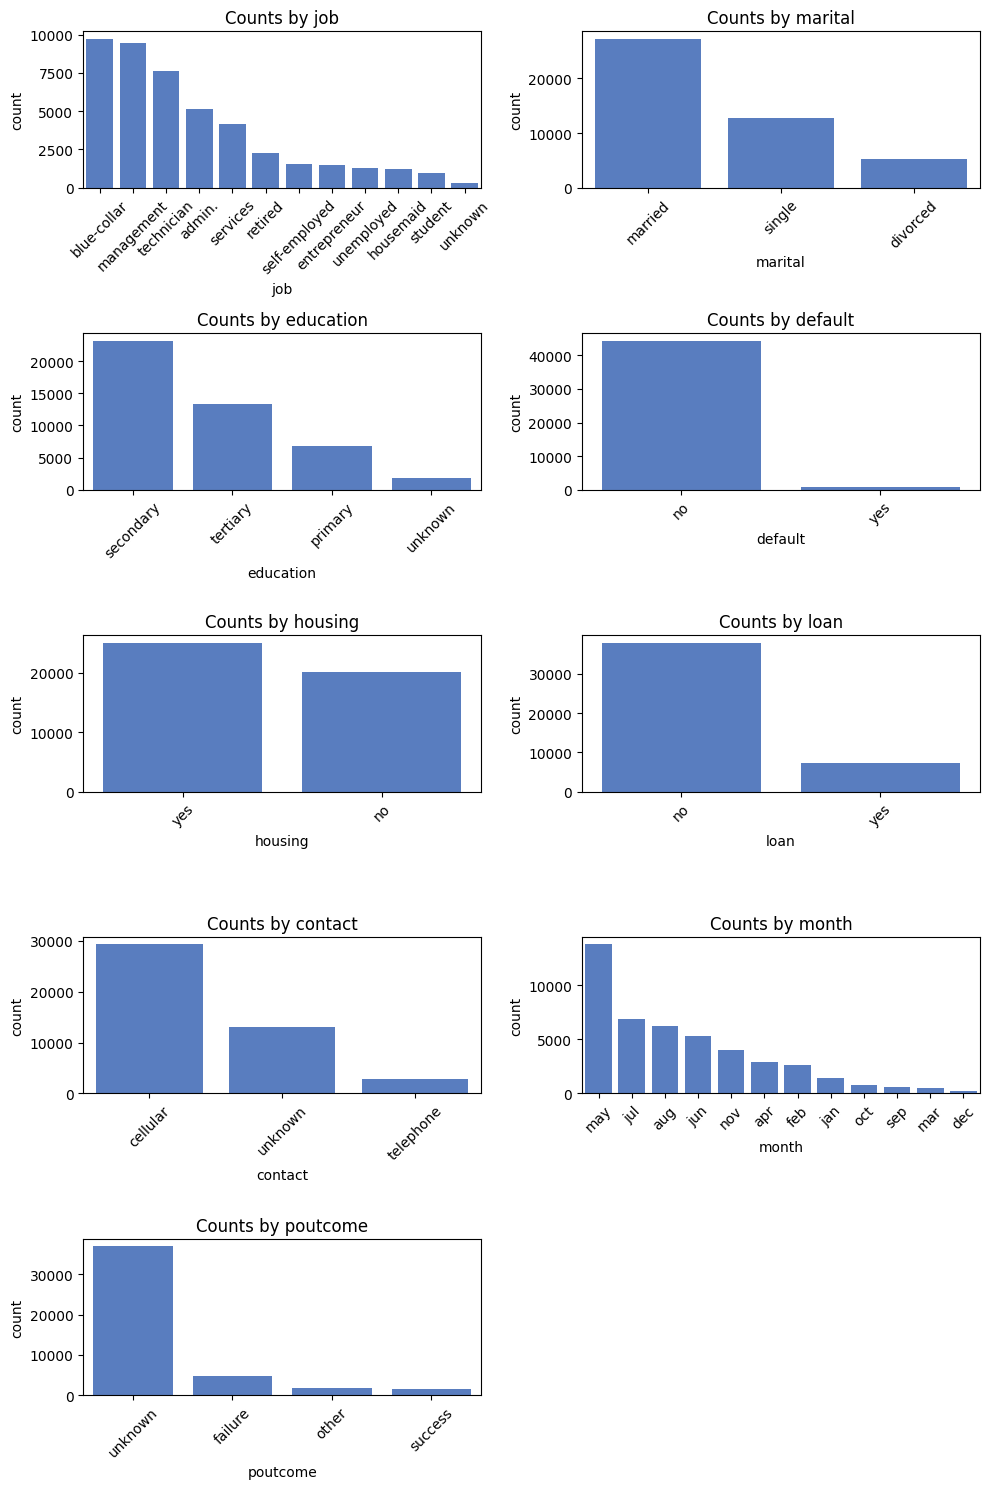

In [8]:
categorical_columns = [c for c in bank.columns if bank[c].dtype == 'object' and c not in ['y']]

plt.figure(figsize=(10, 15))

for i, col in enumerate(categorical_columns, 1):
    plt.subplot(5,2,(i))
    order = bank[col].value_counts().index
    sns.countplot(data=bank, x=col, order=order, color=default_color)
    plt.xticks(rotation=45)
    plt.title(f"Counts by {col}")

plt.savefig("Distribution.png")
plt.tight_layout()
plt.show()

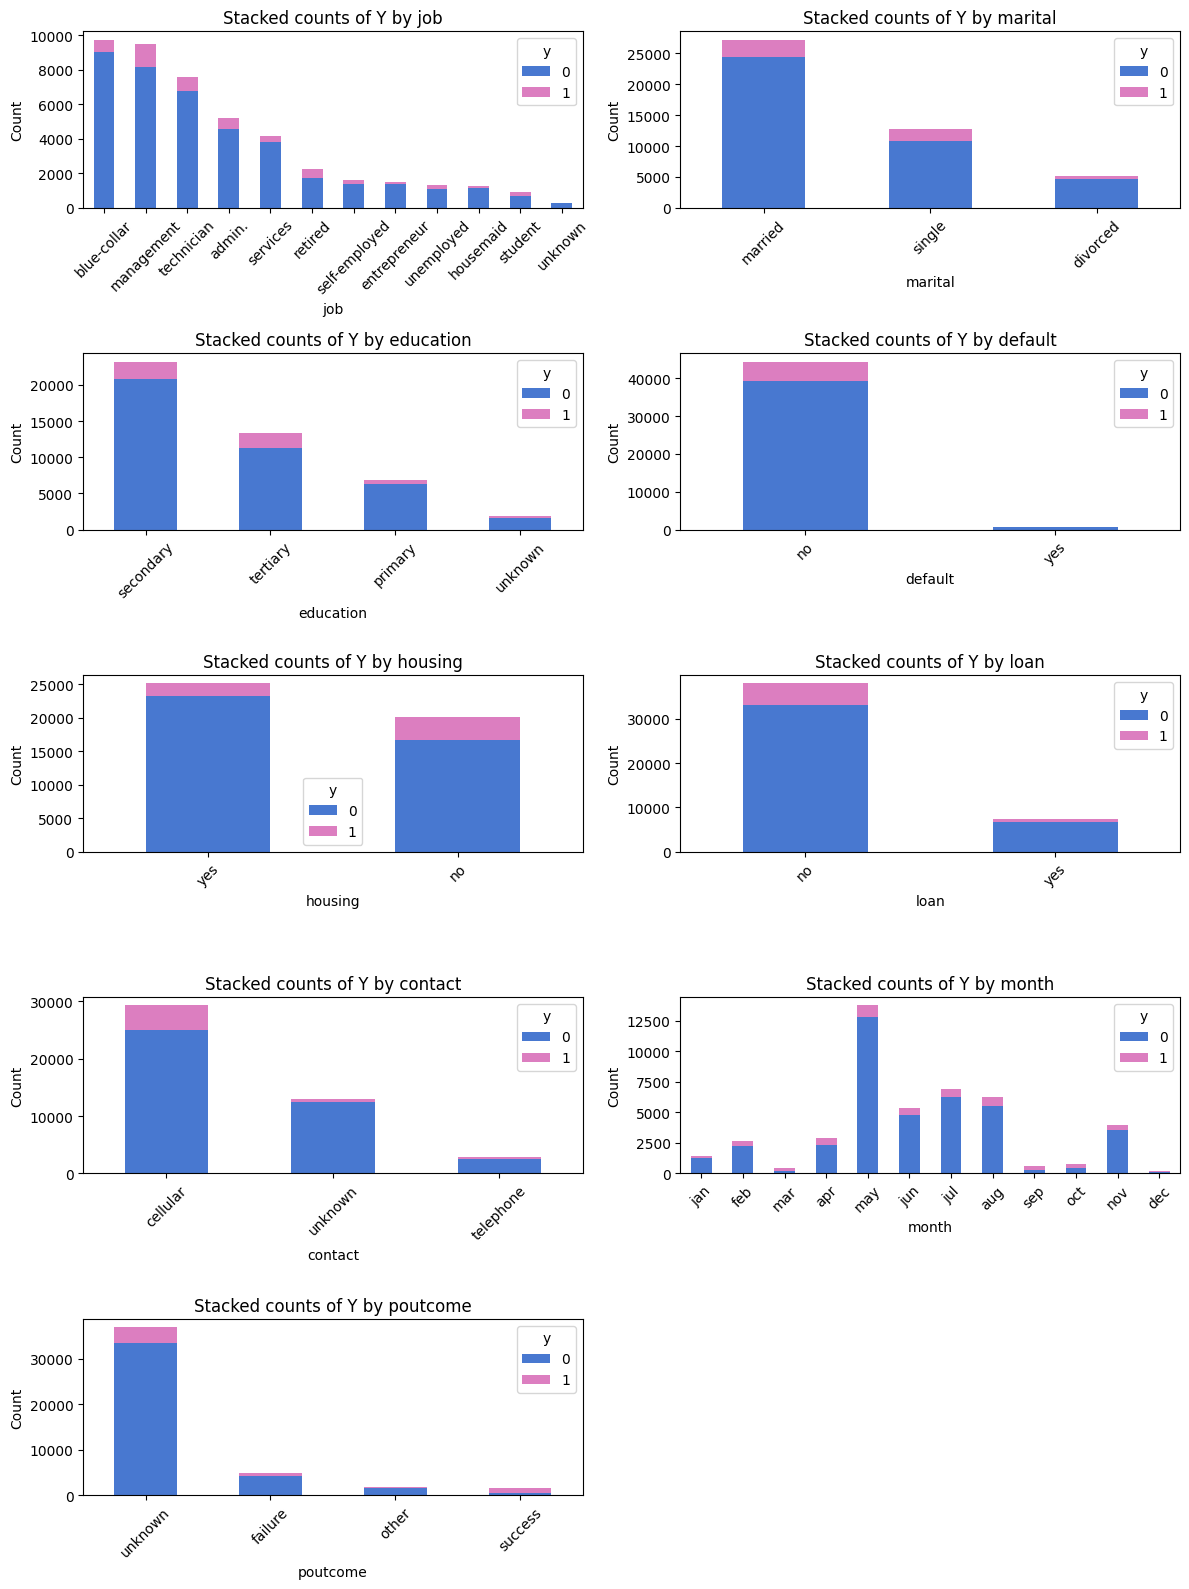

In [9]:
# aestetic features
palette = [default_color, secondary_color]
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 
               'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

plt.figure(figsize=(12, 16))

for i, col in enumerate(categorical_columns, 1):
    ct = pd.crosstab(bank[col], bank['y']).astype(int)

    if col == 'month':
        ct = ct.reindex(month_order, fill_value=0)
    else:
        order = bank[col].value_counts().index
        ct = ct.reindex(order, fill_value=0)

    ax = plt.subplot(5, 2, i)
    ct.plot(kind='bar', stacked=True, color=palette, ax=ax)
    ax.set_title(f"Stacked counts of Y by {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("StackedDistribution.png")
plt.show()

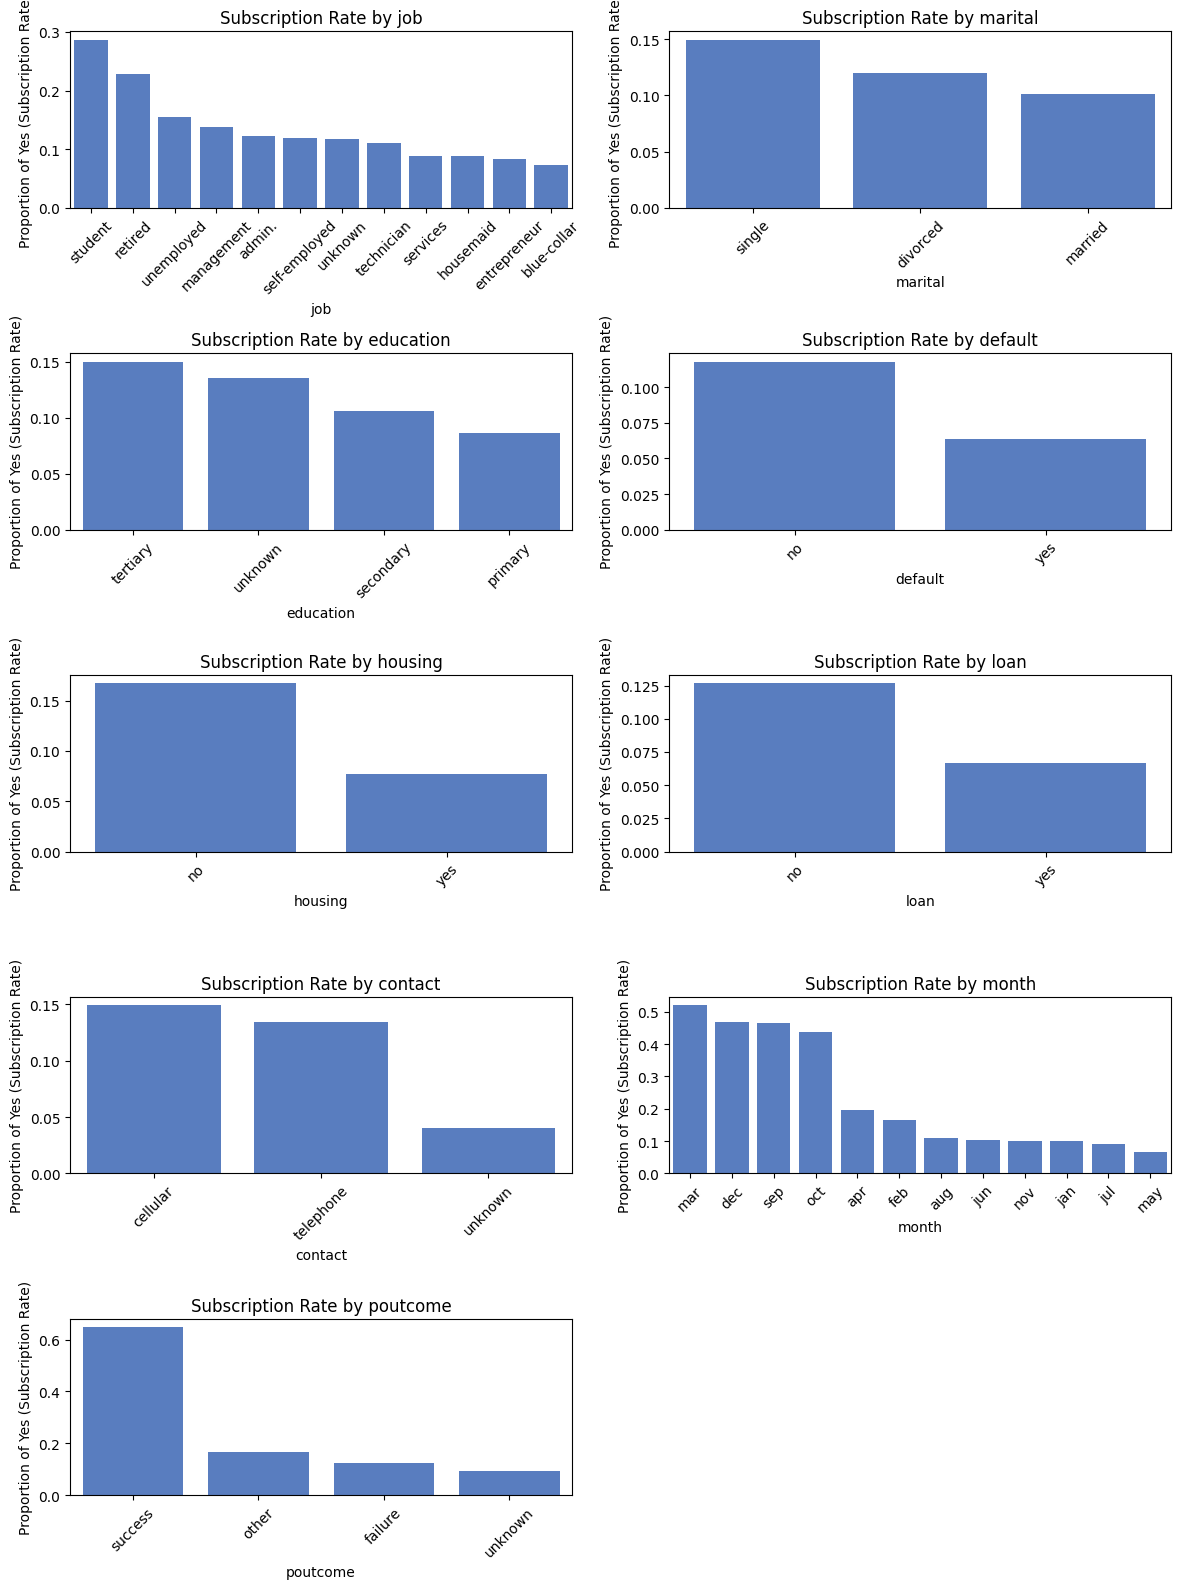

In [10]:
plt.figure(figsize=(12, 16))

for i, col in enumerate(categorical_columns, 1):
    
    summary = bank.groupby(col)['y'].mean().reset_index()
    summary = summary.sort_values('y', ascending=False)

    ax = plt.subplot(5, 2, i)
    sns.barplot(x=col, y='y', data=summary, dodge=False, color=default_color, ax=ax)
    ax.set_ylabel('Proportion of Yes (Subscription Rate)')
    ax.set_xlabel(col)
    ax.set_title(f'Subscription Rate by {col}')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("SubRates.png")
plt.show()

In [11]:
for col in categorical_columns:
    contingency_table = pd.crosstab(bank[col], bank['y'])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    print(f"Chi-square p-value of {col}: {p:.5f}")

Chi-square p-value of job: 0.00000
Chi-square p-value of marital: 0.00000
Chi-square p-value of education: 0.00000
Chi-square p-value of default: 0.00000
Chi-square p-value of housing: 0.00000
Chi-square p-value of loan: 0.00000
Chi-square p-value of contact: 0.00000
Chi-square p-value of month: 0.00000
Chi-square p-value of poutcome: 0.00000


Checking for class imbalance

In [12]:
class_counts = bank['y'].value_counts()
print(class_counts)

y
0    39922
1     5289
Name: count, dtype: int64


In [13]:
print(bank['y'].value_counts(normalize=True))

y
0    0.883015
1    0.116985
Name: proportion, dtype: float64


11.7 % of customers subscribed to a new product. This means that the dataset is imabalnced and will need adjustment later on 

# Modeling

For now, decided to leave in all features and use RFE (recursive feature elimination) later on to eliminate unrelevant features. Expecting duration, month, job category and previous campaign outcome to remain as relevant ones

In [14]:
features = [
    'age','job','marital','education','default','balance','housing','loan',
    'contact','day','month','duration','campaign','pdays','previous','poutcome'
]

Split dataset into training and testing

In [15]:
X = bank[features].copy() # Features
y = bank['y'].copy() # Target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1/3, stratify=y, random_state=10
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (30140, 16) Test shape: (15071, 16)


## Transforming data

Usng standartscaler() to standartize numeric columns to have the same scale

In [16]:
print(numeric_columns)
print(categorical_columns)

['age', 'balance', 'duration', 'campaign', 'pdays', 'previous', 'day']
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


In [17]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine both transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ],
remainder='passthrough'
)

# Fit on training data, then transform both train and test sets
X_train_t = preprocessor.fit_transform(X_train)
X_test_t  = preprocessor.transform(X_test)

print("Transformed X_train shape:", X_train_t.shape)
print("Transformed X_test shape:", X_test_t.shape)

Transformed X_train shape: (30140, 51)
Transformed X_test shape: (15071, 51)


In [18]:
print(X_train_t[:2])

[[ 0.56956604 -0.40656066 -0.57880089 -0.57200222 -0.40876365 -0.23583541
   0.61820196  0.          0.          0.          1.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          1.          0.          1.          0.
   0.          0.          1.          0.          1.          0.
   0.          1.          0.          1.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          1.          0.          0.          0.
   0.          0.          1.        ]
 [-1.03524147  2.64693288 -0.49793201  2.3402394  -0.40876365 -0.23583541
   1.21784175  0.          0.          0.          0.          0.
   0.          0.          0.          0.          1.          0.
   0.          0.          0.          1.          0.          1.
   0.          0.          1.          0.          1.          0.
   0.          1.          1.          0.          0.          0.
   1.          0.    

After seeing that the transformed result is a numPy array and not a dataframe anymore, decided to look for ways to get a list of newly created features

In [19]:
def get_feature_names_from_column_transformer(ct, input_features):
    """
    Returns list of feature names after ColumnTransformer
    (works for OneHotEncoder and StandardScaler pipelines used above).
    """
    feature_names = []
    for name, transformer, cols in ct.transformers_:
        if name == 'remainder' and transformer == 'drop':
            continue
        if hasattr(transformer, 'get_feature_names_out'):
            # OneHotEncoder
            names = transformer.get_feature_names_out(cols)
            feature_names.extend(names.tolist())
        else:
            # scaler -> use original col names
            feature_names.extend(cols)
    return feature_names

feature_names = get_feature_names_from_column_transformer(preprocessor, X_train.columns)
print("Number of transformed features:", X_train_t.shape[1])
print(feature_names)

Number of transformed features: 51
['age', 'balance', 'duration', 'campaign', 'pdays', 'previous', 'day', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'education_primary', 'education_secondary', 'education_tertiary', 'education_unknown', 'default_no', 'default_yes', 'housing_no', 'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular', 'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_failure', 'poutcome_other', 'poutcome_success', 'poutcome_unknown']


Going back to the imbalance of the dataset. Decided to use SMOTE to produce synthetic data for category y = 1, which was underrepresented. 

In [34]:
smote = SMOTE(random_state=10)

X_resampled, y_resampled = smote.fit_resample(X_train_t, y_train)

print("After SMOTE:", X_resampled.shape, y_resampled.shape)
print("Resampled positive rate:", y_resampled.mean())

After SMOTE: (53228, 51) (53228,)
Resampled positive rate: 0.5


Using RFECV to pick relevant features. Compared to simple RFE, which needs setting how many features should be left in advance, RFECV automatically finds the optimal number of features using cross-validation.

In [21]:
# LogisticRegression as the estimator inside RFECV
base_estimator = LogisticRegression(max_iter=2000, solver='liblinear')  # solver ok for small-medium data

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
rfecv = RFECV(
    estimator=base_estimator,
    step=1, 
    cv=cv,
    scoring='roc_auc',# evaluate by AUC during feature selection
    min_features_to_select=5
)

# Fit RFECV on SMOTE'd training data
rfecv.fit(X_resampled, y_resampled)

print("RFECV optimal number of features:", rfecv.n_features_)


RFECV optimal number of features: 42


In [35]:
support_mask = rfecv.support_  # boolean mask of selected features
ranking = rfecv.ranking_  # rank: 1 means selected

selected_feature_names = [fname for fname, keep in zip(feature_names, support_mask) if keep]
ranking_df = pd.DataFrame({
    'feature': feature_names,
    'selected': support_mask,
    'rank': ranking
}).sort_values('rank')

print(support_mask)
print("Selected features ({}):\n".format(len(selected_feature_names)), selected_feature_names)


[False False  True  True False False  True  True False  True  True  True
  True  True False  True False  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True]
Selected features (42):
 ['duration', 'campaign', 'day', 'job_admin.', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_student', 'job_unemployed', 'marital_divorced', 'marital_married', 'marital_single', 'education_primary', 'education_secondary', 'education_tertiary', 'education_unknown', 'default_no', 'default_yes', 'housing_no', 'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular', 'contact_telephone', 'contact_unknown', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_failure', 'poutcome_other', 'poutcome_success', 'poutco

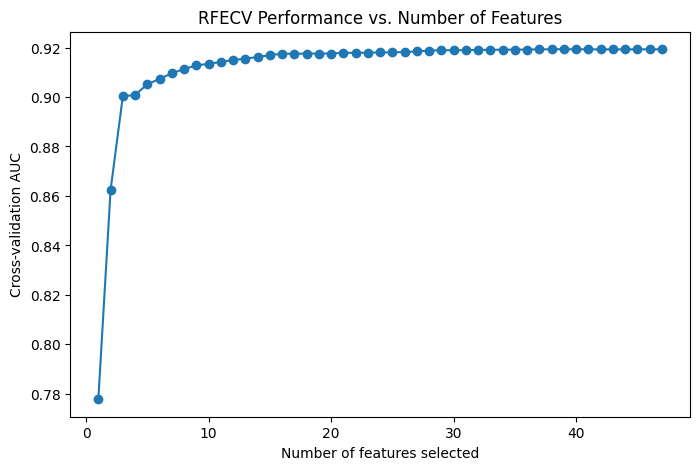

In [23]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1),
         rfecv.cv_results_['mean_test_score'], marker='o')
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation AUC")
plt.title("RFECV Performance vs. Number of Features")
plt.savefig("RFECV.png")
plt.show()

Recursive feature elimination with cross-validation indicated that most features contribute predictive value. Removing any more led to lower AUC, so 42 of 51 were retained

## Logistic Regression

In [24]:
X_resampled_sel = X_resampled[:, support_mask] #keeping only the features that RFECV chose
X_test_sel = X_test_t[:, support_mask]

final_model = LogisticRegression(max_iter=2000, solver='liblinear')
final_model.fit(X_resampled_sel, y_resampled)
print(final_model.n_iter_)

[6]


## Model Testing

Test AUC: 0.9071177381096687

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.85      0.91     13308
           1       0.42      0.81      0.55      1763

    accuracy                           0.85     15071
   macro avg       0.70      0.83      0.73     15071
weighted avg       0.91      0.85      0.87     15071



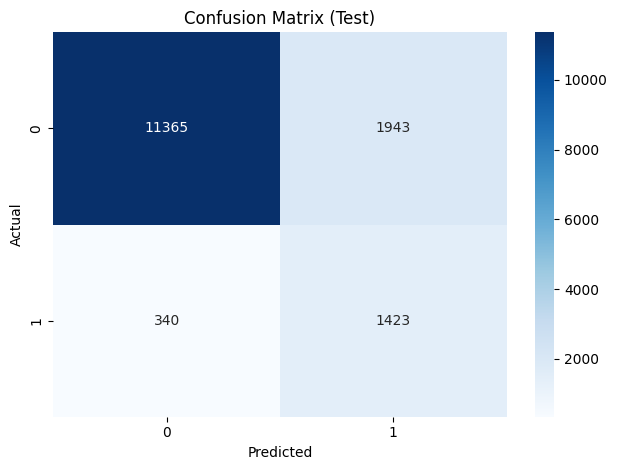

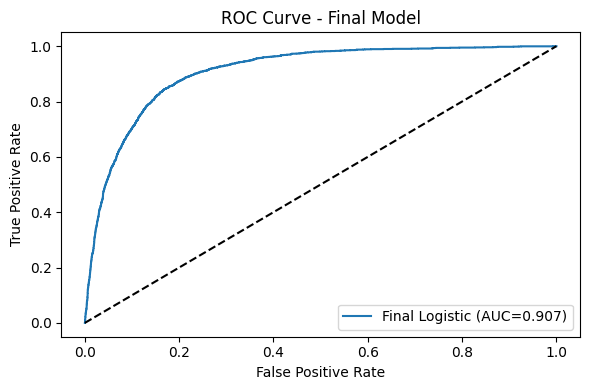

In [26]:
y_proba_test = final_model.predict_proba(X_test_sel)[:,1]
y_pred_test = final_model.predict(X_test_sel)

auc = roc_auc_score(y_test, y_proba_test)
print("Test AUC:", auc)

# Confusion matrix & classification report
print("\nClassification report:\n", classification_report(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Test)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig("Confusion matrix")
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba_test)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'Final Logistic (AUC={auc:.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Final Model')
plt.legend()
plt.tight_layout()
plt.savefig("ROC.png")
plt.show()


The model demonstrates strong discrimination ability (AUC ≈ 0.91) but produces many false positives when evaluated at the default 0.5 threshold (precision ≈ 0.42). 

Test AUC: 0.907


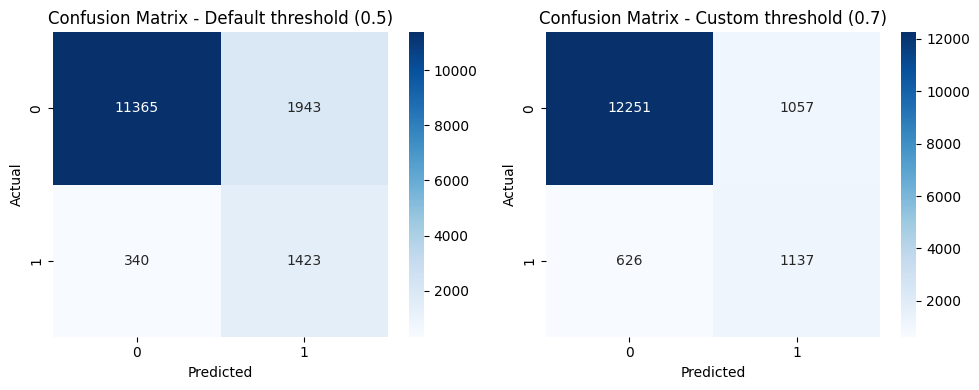


Classification report (default threshold = 0.5):
              precision    recall  f1-score   support

           0       0.97      0.85      0.91     13308
           1       0.42      0.81      0.55      1763

    accuracy                           0.85     15071
   macro avg       0.70      0.83      0.73     15071
weighted avg       0.91      0.85      0.87     15071


Classification report (custom threshold = 0.7):
              precision    recall  f1-score   support

           0       0.95      0.92      0.94     13308
           1       0.52      0.64      0.57      1763

    accuracy                           0.89     15071
   macro avg       0.73      0.78      0.76     15071
weighted avg       0.90      0.89      0.89     15071



In [31]:
# Predict probabilities
y_proba_test = final_model.predict_proba(X_test_sel)[:, 1]

threshold_default = 0.5
y_pred_default = (y_proba_test >= threshold_default).astype(int)

threshold_custom = 0.7
y_pred_custom = (y_proba_test >= threshold_custom).astype(int)

auc = roc_auc_score(y_test, y_proba_test)
print(f"Test AUC: {auc:.3f}")

# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for ax, y_pred, title in zip(
    axes,
    [y_pred_default, y_pred_custom],
    ['Default threshold (0.5)', 'Custom threshold (0.7)']
):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix - {title}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.savefig("Matrix.png")
plt.show()

# Classification reports
print("\nClassification report (default threshold = 0.5):")
print(classification_report(y_test, y_pred_default))

print("\nClassification report (custom threshold = 0.7):")
print(classification_report(y_test, y_pred_custom))


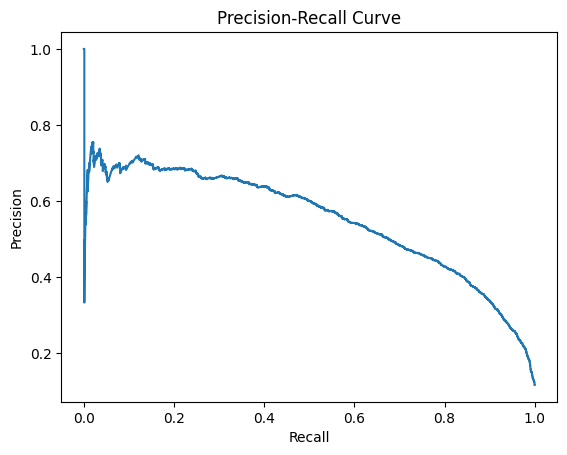

In [32]:
prec, rec, thr = precision_recall_curve(y_test, y_proba_test)
plt.plot(rec, prec)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.savefig("Precision-Recall")
plt.show()

In [33]:
k = 0.10  # top 10%
y_proba = y_proba_test  # predicted probabilities
y_true = y_test.values if hasattr(y_test, "values") else y_test  # ensure it's an array

# Get top k% by predicted probability
n_top = int(len(y_proba) * k)
order = np.argsort(-y_proba)  # descending order
top_idxs = order[:n_top]

# Compute precision at top k%
precision_at_k = y_true[top_idxs].mean()
print(f"Precision at top {int(k*100)}% (top {n_top} samples): {precision_at_k:.3f}")

#Relative Lift vs random
base_rate = y_true.mean()
lift_at_k = precision_at_k / base_rate
print(f"Lift at top {int(k*100)}%: {lift_at_k:.2f}x better than random")


Precision at top 10% (top 1507 samples): 0.595
Lift at top 10%: 5.08x better than random
